## Optimization for Machine Learning and Neural Networks
### Prof. Giovanni Neglia - Tareq Salem
### Student Names: Franz Franco, Minh Nhat Do

#### Momentum method and Nesterov's Accelerated Gradient
Momentum method is a technique for accelerating the stochastic gradient descent(SGD) method, the momentum update can be motivated from a physical perspective by introducing a velocity component. A velocity vector is accumulated in directions that consistenly reduce the cost function, allowing update the parameters in a direction that is more effective than steepest descent. Nesterov's accelerated gradient(NAG) is a variant of momentum method, the main difference is that we also apply a momentum update to the parameters and the gradient is computed with these updated parameters in each step. Momentum methods approach most of the time achieve better convergence rates on deep neural networks compared with vanilla SGD.

Optimizers:
* Full Batch Gradient Descent
* Mini batch gradient descent
* Momentum Method
* Nesterov's Accelerated Gradient

#### Toy example: Linear Regression

In [1]:
# importing libraries
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
if not os.path.exists('results'):
    os.mkdir('results')

Synthetically creating points around the line 
$$
y = ax + b
$$
by adding noise to the output. So, effectively,  
$$
y = ax + b + \varepsilon, \quad where 
$$
$$
\varepsilon \in N(0, \sigma^2)
$$

In [2]:
x_min = -20
x_max = 20
N_samples = 800
noise_level = 3
a = -3
b = 10
#defining function ground truth f(x)
def f(x):
    return(a*x + b) 

# definine function for sampling from f(x) and add some noise
def sample_data_batch_noise(x_min,x_max, N_samples, noise_level):    
    ## The x-data is fixed (no variability here)
    X = np.linspace(x_min,x_max,N_samples)
    noise = noise_level * np.random.randn(N_samples)
    ## The variability here depends only from the noise we add on the samples
    return [X,f(X) + noise]

x, y = sample_data_batch_noise(x_min, x_max, N_samples, noise_level)

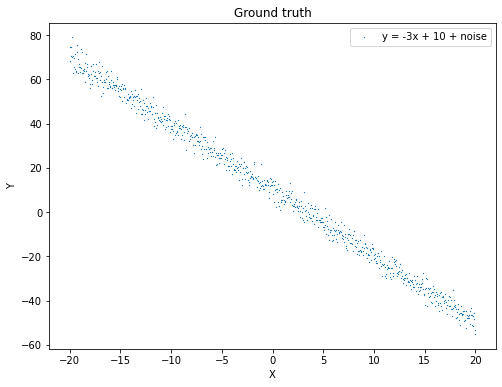

In [3]:
plt.figure(figsize = [8,6])
plt.scatter(x, y, marker='x', s=0.1)
plt.xlabel('X'); plt.ylabel('Y')
plt.title("Ground truth")
plt.legend( ['y = ' + str(a) + 'x + ' + str(b) +' + noise'])
plt.savefig('results/ground_truth.png')
plt.show()

The data is shown above is a line with gaussian noise added. Where the ground truth is known: $y=-3x+10$

We start with some initial pair (a,b) and moving as per the directions of the optimizer till we find the value of (a,b) minimizes the mean squared error over all data points (global minima) or a batch of data points (local minima). 

We define the Mean Square Error function: 
$$
Rs = \frac{1}{n}\sum_{i=1}^n(y_i - (a x_i + b) )^2 
$$

In [4]:
# Compute loss
def compute_loss(a, b):
    return np.mean(np.square(y - (a*x + b)),2)

In [5]:
# Visualizing the loss function for all values of a and b.
a_range, a_step = 20, 0.1
b_range, b_step = 200, 1

# Getting full ranges
a_range_ = np.arange(a - a_range, a + a_range, a_step)
b_range_ = np.arange(b - b_range, b + b_range, b_step)

# Make them into a grid
bgrid, agrid = np.meshgrid(b_range_, a_range_)

# Computing the loss function
size_x = np.int(a_range/a_step*2)
size_y = np.int(b_range/b_step*2)
agrid_tiled = np.tile(np.reshape(agrid, [size_x, size_y, 1]), [1,1,x.shape[0]])
bgrid_tiled = np.tile(np.reshape(bgrid, [size_x, size_y,1]), [1,1,x.shape[0]])
loss_full_grid = compute_loss(agrid_tiled, bgrid_tiled)

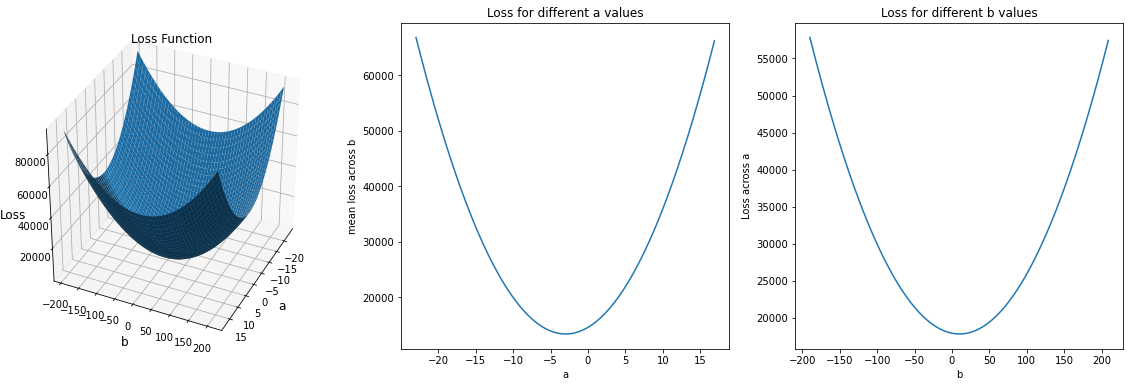

In [6]:
# Spherical coordinate system 
azimuth_angle = 25
elevation_angle = 35

fig = plt.figure(figsize = [20,6])
ax = fig.add_subplot(131, projection = '3d')
ax.view_init(elev = elevation_angle, azim = azimuth_angle)
ax.plot_surface(agrid, bgrid, loss_full_grid)
ax.set_xlabel('a', fontsize=12);  ax.set_ylabel('b', fontsize=12)
ax.set_zlabel('Loss', fontsize=12)
ax.set_title('Loss Function', fontsize=12)
ax = fig.add_subplot(132)
plt.plot(a_range_, np.mean(loss_full_grid, axis=1))
plt.xlabel('a')
plt.ylabel('mean loss across b')
plt.title('Loss for different a values')
ax = fig.add_subplot(133)
plt.plot(b_range_, np.mean(loss_full_grid, axis=0))
plt.xlabel('b')
plt.ylabel('Loss across a')
plt.title('Loss for different b values')
plt.savefig('results/loss_f.png')
plt.show()

### Ridge Regression solution

The solution to this mean squared minimization with Ridge regression approach, This can be expressed as :
$$
   Y= \omega^{T} X + \lambda   \| \omega \| ^{2} 
$$

$$
\omega = (X^T X)^{-1}X^T Y
$$

where $X$ is the features set with a column of 1's appended for the intercept value computation 

In [7]:
from numpy import identity as I
from numpy import matmul as M
from numpy.linalg import inv

# function compute_w1
def compute_w1(X, y, _lambda):
    n = X.shape[0]
    d = 1
    X_t = np.ones((n,d+1))
    X_t[:,1:] = X.reshape(n,d)
    w1 = M(M(inv(M(X_t.T, X_t) + n*_lambda*I(d+1)), X_t.T), y)
    return w1

# function predict_1
def predict_1(X, w1):
    n = X.shape[0]
    d = 1
    X_t = np.ones((n,d+1))
    X_t[:,1:] = X.reshape(n,d)
    y_pred = M(X_t, w1)
    return y_pred

In [8]:
_lambda = 0.01
w1 = compute_w1(x, y, _lambda)
print("#####Ground truth#####")
print('a: ', a, 'b: ', b)
print("#####Ridge Solution#####")
print('a_pred: ',round(w1[1],3), 'b_pred: ', round(w1[0],3))

#####Ground truth#####
a:  -3 b:  10
#####Ridge Solution#####
a_pred:  -2.993 b_pred:  9.907


### Gradients computation
Computing the gradients w.r.t a and b, we have
$$
J = \frac{1}{n}\sum_{i=1}^n(y_i - (a x_i + b) )^2 ,           \nabla J = ( \frac{\partial J}{\partial a} , \frac{\partial J}{\partial b})
$$

In [9]:
#Computing grad for a and b
def gradient(x, y, theta):
    a,b = theta[0], theta[1]
    err = a * x + b - y
    loss = sum(err * err)
    grad_a = sum(x * err)
    grad_b = sum(err)
    return np.array([grad_a, grad_b]), loss

# It does what the name says it does..
def get_random_batch(x, y, batch_size):
    i = np.random.randint(0, x.shape[0]-1, size = batch_size)
    return(x[i], y[i])

# Plot function
def plot_all_results(model_name, grad, abvalue, loss, velocity = None):
    plt.figure(figsize = [20, 6])
    plt.subplot(141)
    plt.plot(abvalue[:,0])
    plt.title('"a" values'); plt.xlabel("# Steps")
    plt.ylabel('a')
    plt.subplot(142)
    plt.plot(abvalue[:,1])
    plt.title('"b" values'); plt.xlabel("# Steps")
    plt.ylabel('b')
    plt.subplot(143)
    plt.plot(loss)
    plt.title("Loss"); plt.xlabel("# Steps")
    plt.ylabel('loss')
    if velocity is not None:
        plt.subplot(144)
        plt.plot(velocity[:, 0])
        plt.plot(velocity[:, 1], 'r*')
        plt.legend(['Velocity of grad_a', 'Velocity of grad_b'])
    plt.suptitle('Results on '+model_name+': value updates and Loss') # or plt.suptitle('Main title')
    
    plt.savefig('results/{}.png'.format(model_name))
    plt.show()

# Initializing data
def init_data(num_epochs):
    grad = np.zeros([num_epochs, 2], dtype=float)
    abvalue = np.zeros([num_epochs, 2], dtype=float)
    loss = np.zeros([num_epochs, 1], dtype=float)
    velocity = np.zeros([num_epochs, 2], dtype=float)
    return grad, abvalue, loss, velocity

#getting the batch of data for passed indices
def get_data_from_batch(x,y,idx,batch_size):
    start_ix = idx*batch_size
    end_ix   = min(start_ix + batch_size, x.shape[0])
    return (x[start_ix:end_ix], y[start_ix:end_ix])

# shuffle the array
ix = np.arange(0,x.shape[0])
np.random.shuffle(ix)
x = x[ix]
y = y[ix]

### Initializing parameters

In [10]:
#Random initialization for a and b
initial_a = 8
initial_b = 75
#Number of epochs
num_epochs_fb = 1000 # epochs for full batch
num_epochs = 100
#learning rate
alpha_fb = 5e-6  # learning rate for full batch
alpha = 5e-5
#Batch size
batch_size = 150
#Number of batches
n_batches = int(x.shape[0]/batch_size)
#Momentum constant
gamma = 0.9
print("#####Gradient Computation#####")
print("###Initializing parameters###")
print("Initial a = ", initial_a)    
print("Initial b = ", initial_b)
print("Epochs = ", num_epochs)
print("Learning rate = ", alpha)
print("Batch_size = ", batch_size)
print("Number of batches = ", n_batches)
print("Momentum constant = ", gamma)

#####Gradient Computation#####
###Initializing parameters###
Initial a =  8
Initial b =  75
Epochs =  100
Learning rate =  5e-05
Batch_size =  150
Number of batches =  5
Momentum constant =  0.9


### Full Batch Gradient Descent

$$
\theta_{t+1} = \theta_{t} - \alpha \cdot \nabla F(\theta_{t})
$$


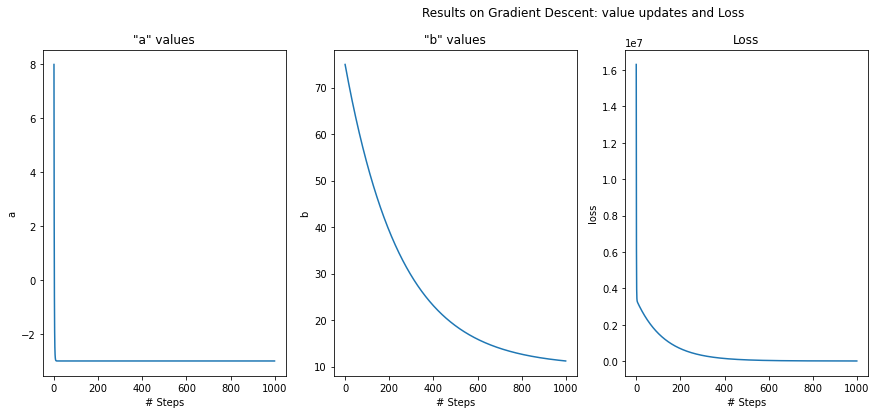

#####Full Batch Gradient Descent#####
###############Results###############
Initial a_pred =  -2.992973505813105
Initial b_pred =  11.191405392675422
Loss =  [8051.13924894]


In [11]:
# Full Batch gradient descent
grad_store, abvalue_store, loss_store, _ = init_data(num_epochs_fb)

theta = np.array([initial_a, initial_b])

for i in range(num_epochs_fb):
    abvalue_store[i,:] = theta
    
    #calculate gradient
    grad, loss = gradient(x,y, theta)
    #update rule
    delta_theta = alpha_fb * grad
    theta = theta - delta_theta
    # storing them to display later
    grad_store[i] = grad
    loss_store[i] = loss
    
plot_all_results("Gradient Descent", grad_store, abvalue_store, loss_store)

print("#####Full Batch Gradient Descent#####")
print("###############Results###############")
print("Initial a_pred = ", abvalue_store[-1][0])    
print("Initial b_pred = ", abvalue_store[-1][1])
print("Loss = ", loss_store[-1])

### Mini batch gradient descent

$$
\theta_{t+1} = \theta_{t} - \alpha \cdot \nabla f(\theta_{t})
$$

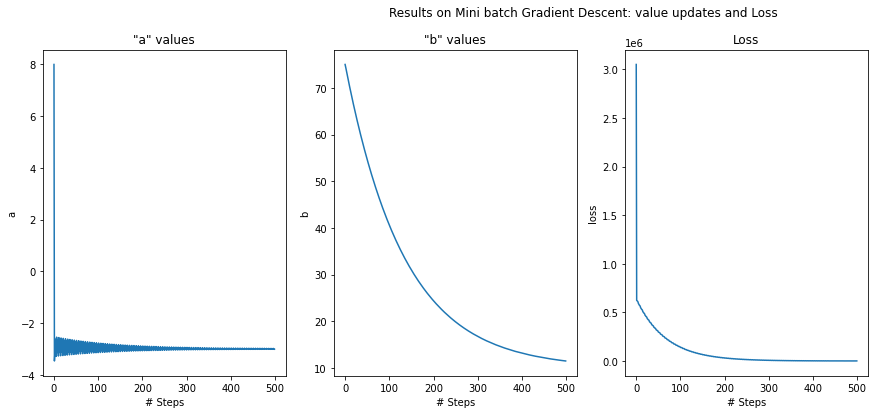

#####Mini batch gradient descent#####
###############Results###############
Initial a_pred =  -3.0013261998919214
Initial b_pred =  11.526717548662324
Loss =  [2074.40775322]


In [12]:
# Mini batch gradient descent
grad_store, abvalue_store, loss_store, velocity_store = init_data(num_epochs*n_batches)

theta = np.array([initial_a, initial_b])

i=0
for epoch in range(num_epochs):   
    for batch_idx in range(n_batches):
        abvalue_store[i] = theta
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        
        #calculate gradient
        grad, loss = gradient(x_batch, y_batch, theta)
        
        # update parameters
        theta = theta - alpha * grad
        
        grad_store[i] = grad
        loss_store[i] = loss
        i += 1
    
plot_all_results("Mini batch Gradient Descent", grad_store, abvalue_store, loss_store)
print("#####Mini batch gradient descent#####")
print("###############Results###############")
print("Initial a_pred = ", abvalue_store[-1][0])    
print("Initial b_pred = ", abvalue_store[-1][1])
print("Loss = ", loss_store[-1])

Observe the noisy convergence in the above case when we used mini batches of data. Vary the batch size parameter above and observe the variations in the result. 

### Momentum

* To lead to faster convergence when gradient changes slowly along one of the dimensions as is the case above

$$
v_{t+1} = \mu v_{t} - \alpha \nabla f(\theta_{t})
$$

$$
\theta_{t+1} = \theta_{t} + v_{t+1}
$$

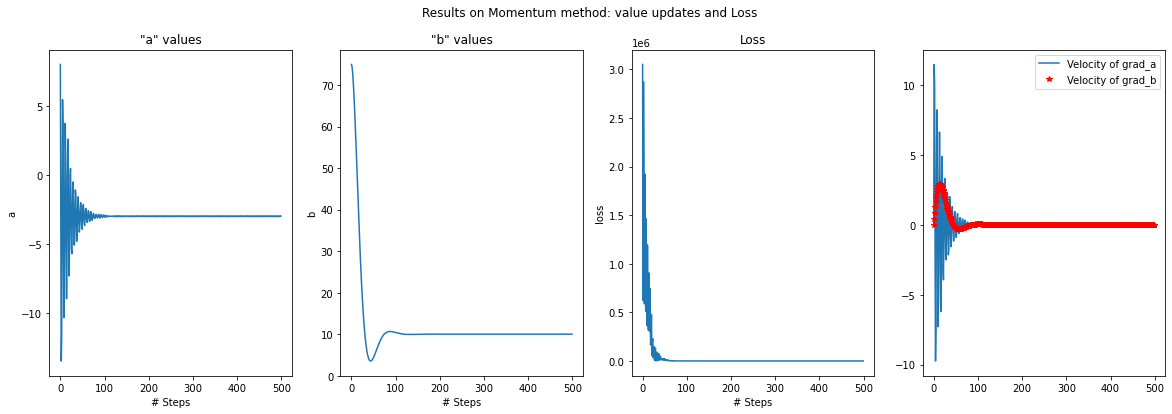

###########Momentum Method###########
###############Results###############
Initial a_pred =  -2.9838956794999976
Initial b_pred =  10.019286806199583
Loss =  [1720.80928968]


In [13]:
#Momentum
grad_store, abvalue_store, loss_store, velocity_store = init_data(num_epochs*n_batches)


theta = np.array([initial_a, initial_b])
velocity = np.array([0, 0])

i=0
for epoch in range(num_epochs):   
    for batch_idx in range(n_batches):
        abvalue_store[i] = theta
        velocity_store[i] = velocity
        
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        
        # calculate gradient
        grad, loss = gradient(x_batch, y_batch, theta)
        
        # update rule
        velocity = gamma* velocity + alpha * grad
        theta = theta - velocity
        
        # store
        grad_store[i] = grad
        loss_store[i] = loss
        i += 1
    
plot_all_results("Momentum method",grad_store, abvalue_store, loss_store, velocity_store)
print("###########Momentum Method###########")
print("###############Results###############")
print("Initial a_pred = ", abvalue_store[-1][0])    
print("Initial b_pred = ", abvalue_store[-1][1])
print("Loss = ", loss_store[-1])

### Nesterov

$$
v_{t+1} = \gamma v_{t} - \alpha \nabla f(\theta_{t} - \gamma v_{t})
$$

$$
\theta_{t+1} = \theta_{t} + v_{t+1}
$$

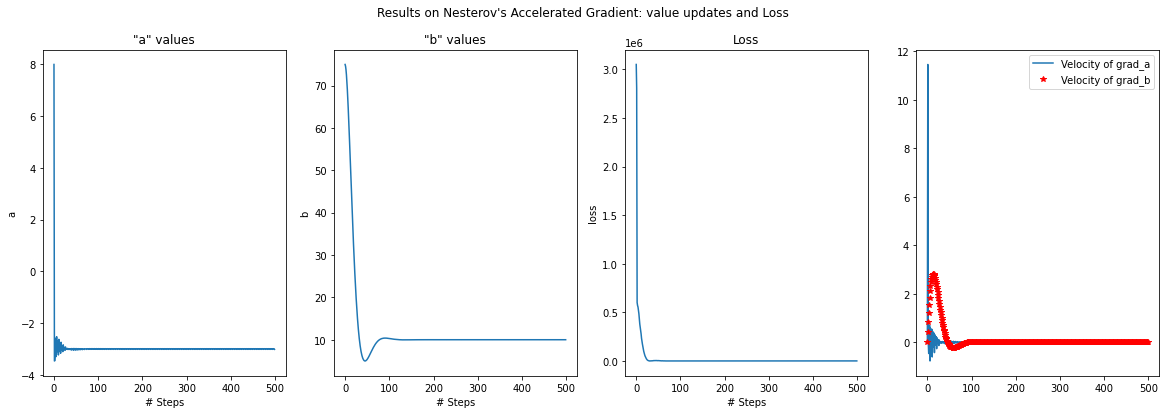

#########Nesterov Accelerated########
###############Results###############
Initial a_pred =  -3.010123533424458
Initial b_pred =  10.023816641310574
Loss =  [1733.52435974]


In [14]:
#Nesterov
grad_store, abvalue_store, loss_store, velocity_store = init_data(num_epochs*n_batches)

theta = np.array([initial_a, initial_b])
velocity = np.array([0, 0])

i=0
for epoch in range(num_epochs):   
    for batch_idx in range(n_batches):
        abvalue_store[i] = theta
        velocity_store[i] = velocity
        
        x_batch, y_batch = get_data_from_batch(x,y, batch_idx, batch_size)
        
        # computing gradient at lookahead theta
        look_ahead_theta = theta - gamma*velocity
        grad, loss = gradient(x_batch, y_batch, look_ahead_theta)
        
        # update the params
        velocity = gamma* velocity + alpha * grad
        theta = theta - velocity
        
        grad_store[i] = grad
        loss_store[i] = loss
        i += 1
    
plot_all_results("Nesterov's Accelerated Gradient", grad_store, abvalue_store, loss_store, velocity_store)
print("#########Nesterov Accelerated########")
print("###############Results###############")
print("Initial a_pred = ", abvalue_store[-1][0])    
print("Initial b_pred = ", abvalue_store[-1][1])
print("Loss = ", loss_store[-1])